# This should be the last time I need to write a secular equation solver.

Having applied the Golub proof to our QCQP, I can now confidently write a secular equation solver that returns only the leftmost solution (which is provably optimal). I can also calculate condition numbers.

## Problem setting
The original problem is

$$
\begin{align*}
&(P') & \min~ & \lambda  \\
& s.t.& z^\top z &= s^2 \\
&& Cz &= \lambda z + b
\end{align*}
$$
After diagonalization, we have
$$
\begin{align*}
&(P') & \min~ & \lambda  \\
& s.t.& u^\top u &= s^2 \\
&& Du &= \lambda u + d
\end{align*}
$$
This matches equation (17) in Gander 1989. Note that $D$ has the following structure:

$$
\begin{align*}
D &= \text{diag}(\delta_1,\ldots,\delta_n),\qquad \delta_1\leq\delta_2\leq\ldots\delta_n
\end{align*}
$$

## Solution
We first need to rule out the case where $\lambda$ is in the spectrum of $D$. If all elements of $d$ are nonzero, there is no solution in this scenario.

Provided $\lambda$ is not in the spectrum of $D$, we can proceed to write the *explicit secular equation*:

$$
\begin{align*}
f(\lambda) &:= \sum_{i=k}^n\left( \frac{d_i}{\delta_i - \lambda}\right)^2 - s^2 = 0~,
\end{align*}
$$
where $k$ is the first index of $d$ such that $d_k\neq 0$.

If all elements of $d$ are zero, the desired solution is $\lambda = \delta_1$, the smallest Eigenvalue of $D$. Otherwise, the desired solution is less than $\delta_1$.

A simple iterative scheme may be used to find the smallest solution $\lambda$, since the derivative is positive on $(-\infty,\delta_k)$.

$$
\begin{align*}
f'(\lambda) &= \sum_{i=k}^n\ \frac{2d_i^2}{(\delta_i-\lambda)^3}
\end{align*}
$$

## Condition of secular equation
If there is some error in our solution so we have $\lambda+\Delta\lambda$ rather than $\lambda$, Gander provides bounds on the corresponding solution vector error and minimal value error.

$$
\begin{align*}
\Delta x &= \kappa(x)\Delta\lambda \\
\Delta \min &= \kappa(\min)\Delta\lambda
\end{align*}
$$

$\kappa(x)$ is the condition vector of $x$, and $\kappa(\min)$ is the condition number of $\min$. They are defined in Gander equations (24) and (25), respectively. From an implementation perspective, the norms of these quantities are most important, as they provide upper bounds on numerical error. From Gander, we have

$$\begin{align*}
\lVert \kappa(x) \rVert &\leq \frac{\lVert d \rVert}{(\delta_1-\lambda)^2} \\
\lvert \kappa(\min) \rvert &< 2\lVert A \rVert \frac{\lVert d \rVert}{(\delta_1-\lambda)^2}
\end{align*}
$$

Gander et al. point out that errors grow large when the desired solution $\lambda$ is close to the smallest Eigenvalue $\delta_1$. They also note that the minimal value is affected more than the solution vector, because the norm of $A$ is typically greater than 1.

## Zero finder
Gander et al. derive an iterative method for determining $\lambda$:

### Iterative scheme
$$
\begin{align*}
\lambda^{(i+1)} &= \lambda^{(i)} - 2\frac{ f(\lambda^{(i)}) + s^2 }{ f'(\lambda^{(i)}) }\left( \frac{ \sqrt{f(\lambda^{(i)}) + s^2}}{s} - 1 \right)
\end{align*}
$$

This process yields a strictly decreasing set of approximations.

### Initial guess
A good initial guess is based on the term of the secular equation corresponding to only the first nonzero element of $d$:

$$
\begin{align*}
\lambda^{(0)} &= \delta_k - \frac{\lvert d_k\rvert }{s}
\end{align*}
$$

### Stopping criterion
Gander et al. propose termination when the iterates stop decreasing (in other words, when finite arithmetic can no longer keep up with the theory). We stop when $\lambda^{(i+1)} \geq \lambda^{(i)}$.

## Julia implementation

In [70]:
"""
Solve the explicit secular equation 
by returning the smallest `v` satisfying

f(v) = w'\*w - s2 = 0,

where `w = d./(D - v)`.

Inputs:

* `d` is a vector with numerator values
* `D` is a vector of poles (no need to sort them)
* `s2` is the target constant; we return solutions s(v) = s2.

Output:

* `val` is the optimal `v` satisfying s(v) = c
* `vecs` is a vector of vectors `w` corresponding to `vals`
"""
function newsolvesecular(
    d::Vector{Float64},
    D::Vector{Float64},
    s2::Float64
    )
    
    # sort eigenvalues by magnitude:
    p = sortperm(D)
    D = D[p]
    d = d[p]
    
    # explicit secular eq
    f(v::Float64) = sumabs2(d./(D-v)) - s2
    
    # derivative:
    fprime(v::Float64) = sum((2*d.^2)./((D-v).^3))
    
    # vector in terms of v
    w(v::Float64) = float(d./(v - D))[invperm(p)]
    
    # index of first nonzero of d
    k = minimum(find(d))
    
    iterates = Vector{Float64}()
    v0 = D[k] - abs(d[k])/sqrt(s2)
    push!(iterates,v0)
    
    stop = false
    while !stop
        v = iterates[end]
        vnew = v - 2*((f(v) + s2)/fprime(v))*(sqrt((f(v)+s2)/s2) - 1)
        push!(iterates,vnew)
        stop = vnew >= v
    end
    v = iterates[end]
    return v, w(v)
end

newsolvesecular (generic function with 1 method)

## Testing and comparing
The single solution returned by the new solver should match the minimal solution returned by the old solver. It should also be much faster.

In [2]:
# plotting imports
using Interact, PyPlot
PyPlot.svg(true)

# import old solver
include("../src/TemporalInstanton.jl")
import TemporalInstanton.solvesecular

  likely near /home/jkersulis/.julia/v0.4/Interact/src/Interact.jl:52
  likely near /home/jkersulis/.julia/v0.4/Interact/src/Interact.jl:53
  likely near /home/jkersulis/.julia/v0.4/Interact/src/Interact.jl:66
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:12
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:12
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:31
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:31
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:45
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:45
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:61
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:61
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:75
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:75


 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/jkersulis/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/jkersulis/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl, in expression starting on line 75
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:75
  likely near /home/jkersulis/.julia/v0.4/Interact/src/widgets.jl:75
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include_string at loading.jl:266
 in execute_reques

In [102]:
# quick comparison
numpoles = 10
num = 0.2*(collect(1:numpoles)) # equiv. to d
poles = -collect(1.:1.:numpoles) # equiv. to D
c = 0.1 # equiv. to s2

@time v,w = solvesecular(num,poles,c);
@time v2,w2 = newsolvesecular(num,poles,c);

# this difference should be very tiny:
println(string("difference: ",round(minimum(vals[1]) - vals2[end],14)))

  0.002538 seconds (15.13 k allocations: 566.781 KB)
  0.000084 seconds (371 allocations: 17.813 KB)
difference: 1.0481e-10


Interact.Slider{Float64}([Reactive.Input{Float64}] 2.6,"c",2.6,0.2:0.2:5.0)

Interact.Slider{Int64}([Reactive.Input{Int64}] 5,"numpoles",5,1:10)

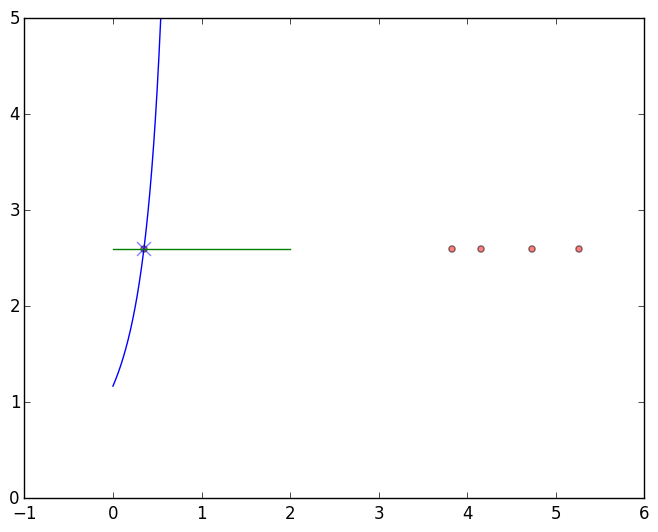

In [92]:
# interactive comparison

fig = figure()
# c = 1.1
# numpoles = 5
@manipulate for c in 0.2:0.2:5, numpoles in 1:10; withfig(fig) do
        num = 0.2*(collect(1:numpoles))
        poles = shuffle!(collect(1.:1.:numpoles))
        xx = collect(linspace(0.0,2*poles[end],1000))
        s(vv::Vector{Float64}) = [sumabs2(num./(v - poles)) for v in vv]  
        
        tiny = c/1e8
        
        vals = solvesecular(num,poles,c)[1]
        vals2 = [newsolvesecular(num,poles,c)[1]]
        
        plot(xx,s(xx))
        ylim([0;5])
        hold(true)
        plot([xx[1];xx[end]],[c;c])
        scatter(vals,s(vals),c="red",alpha=0.5)
        scatter(vals2,s(vals2),marker="x",s=100,c="blue",alpha=0.5)
#         title("new sols: $(length(vals) - length(vals2))")
    end
end
# savefig("../images/2015-09-10-secular.svg")

## Integration into temporal instanton code

In [1]:
include("../src/TemporalInstanton.jl")
using TemporalInstanton,MatpowerCases

  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:3
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:243
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include_string at loading.jl:266
 in execute_request_0x535c5df2 at /home/jkersulis/.julia/v0.4/IJulia/src/execute_request.jl:177
 in eventloop at /home/jkersulis/.julia/v0.4/IJulia/src/IJulia.jl:141
 in anonymous at task.jl:447
while loading /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl, in expression starting on line 3
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:23
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:135


In [2]:
case = "case118"
maxlines = 1000
num_farms = length(unique(loadcase(case,describe=false)["gen"][:,1]))

penetration = 0.5 # penetration of 50 %
d = mat2tmpinst(case)

# Thermal model parameters:
d.Tamb = 35. # C
d.T0 = 60. #46. # initial line steady-state temp

d.time_values = 0:30:300 # five minutes in 30-sec steps
d.int_length = 300. # seconds = 5 min

Gp,Dp,Rp = (d.G0, d.D0, d.R0)
d.G0 = [Gp;Gp;Gp;Gp;Gp;Gp]
d.D0 = [Dp;Dp;Dp;Dp;Dp;Dp]
d.R0 = [Rp;1.1*Rp;1.2*Rp;1.1*Rp;Rp;0.9*Rp]

n = length(d.k)
nr = length(d.Ridx)
T = convert(Int64,length(d.G0)/n)

timed_results = @timed solve_temporal_instanton(d,maxlines);
results = timed_results[1]
o = process_instanton_results(results,n,nr,T,return_as_type=true);

r=0 check: 	removing 9 lines
ISF pre-check: 	flagging [113,177,183,184]
secular savings: 74.65%
secular diff: -2.9649934731423855e-5
secular savings: 91.91%
secular diff: -0.00040401070145890117
secular savings: 92.54%
secular diff: -0.00026419549249112606
secular savings: 90.53%
secular savings: 87.46%
secular diff: -1.5302432075259276e-5
secular savings: 91.8%
secular diff: -3.47165041603148e-5
secular savings: 90.66%
secular diff: -6.209843922988512e-5
secular savings: 91.06%
secular diff: -1.2628484228116577e-5
secular savings: 90.79%
secular diff: -1.5945101040415466e-5
secular savings: 86.35%
secular diff: -1.949362012965139e-5
secular savings: 93.42%
secular savings: 91.98%
secular diff: -7.318623829632998e-5
secular savings: 91.89%
secular savings: 93.34%
secular diff: 1.3305776519700885e-5
secular savings: 91.74%
secular savings: 90.59%
secular savings: 93.86%
secular savings: 92.29%
secular savings: 93.38%
secular savings: 90.57%
secular savings: 92.36%
secular savings: 91.39

As expected, the new method is dramatically more efficient. It cuts down on secular equation solution time by an average of 90%. The largest solution differences are of the order 1e-3, but I am more confident in the new solution method than in my old solver, whose stopping criterion was based on an arbitrary precision setting.

## New timing results
Previously, secular equation solving took about 4.5-5% of total solution time. How big is its slice now?

In [1]:
addprocs(2) # vary number of concurrent processes here
@everywhere include("../src/TemporalInstanton.jl")
@everywhere include("../src/mat2tmpinst.jl")
@everywhere using TemporalInstanton

  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:3
 in depwarn at deprecated.jl:73
 in call at deprecated.jl:50
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in require at ./loading.jl:237
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in include at ./boot.jl:261
 in include_from_node1 at ./loading.jl:304
 in eval at ./sysimg.jl:14
 in anonymous at multi.jl:1350
while loading /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl, in expression starting on line 3
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:23
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:135
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:3
 in depwarn at deprecated.jlWARNING: Base.String is deprecated, use AbstractString instead.
  likely near /home/jkersulis/.julia/v0.4/GraphLayout/src/draw.jl:3
73
 in depwarn at deprecat

In [15]:
# compile everything with this run:
inputData = load_rts96_data(return_as_type=true);
# Thermal model parameters:
inputData.Tamb = 35. # C
inputData.T0 = 60. #46. # initial line steady-state temp

inputData.time_values = 0:30:300 # five minutes in 30-sec steps
inputData.int_length = 300. # seconds = 5 min
Gp,Dp,Rp = inputData.G0,inputData.D0,inputData.R0
inputData.G0 = [0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp;0.7*Gp]
inputData.D0 = [0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp;0.9*Dp]
inputData.R0 = [Rp;1.1*Rp;1.2*Rp;1.3*Rp;1.4*Rp;1.5*Rp]

@time results = solve_temporal_instanton(inputData);

n = length(inputData.k)
nr = length(inputData.Ridx)
T = convert(Int64,length(inputData.G0)/n)
outputData = process_instanton_results(results,n,nr,T,return_as_type=true);

sort(outputData.score)

r=0 check: 	removing 1 lines
ISF pre-check: 	removing lines Int64[]
  

104-element Array{Tuple{Float64,Int64},1}:
 (0.26378783001958556,25)
 (0.3273164183294316,30) 
 (1.2886107366348905,69) 
 (2.2041515936850553,89) 
 (2.322973886043687,118) 
 (2.4231615471272683,64) 
 (4.678755462375116,42)  
 (4.865240811111239,102) 
 (4.899167201157634,31)  
 (5.67826604880591,80)   
 (5.938620037617328,1)   
 (6.439172990445859,100) 
 (6.460888758468737,62)  
 ⋮                       
 (178.08558178622434,99) 
 (303.00328573219656,103)
 (370.6144351201698,66)  
 (370.6144351201698,67)  
 (391.3070873722268,33)  
 (428.94449223312046,40) 
 (923.9799853876223,72)  
 (979.1988880483482,117) 
 (1319.8524187115247,79) 
 (1390.0270570283046,110)
 (1967.2698882361112,73) 
 (1967.2698882361112,74) 

0.553999 seconds (20.89 k allocations: 2.726 MB, 1.67% gc time)


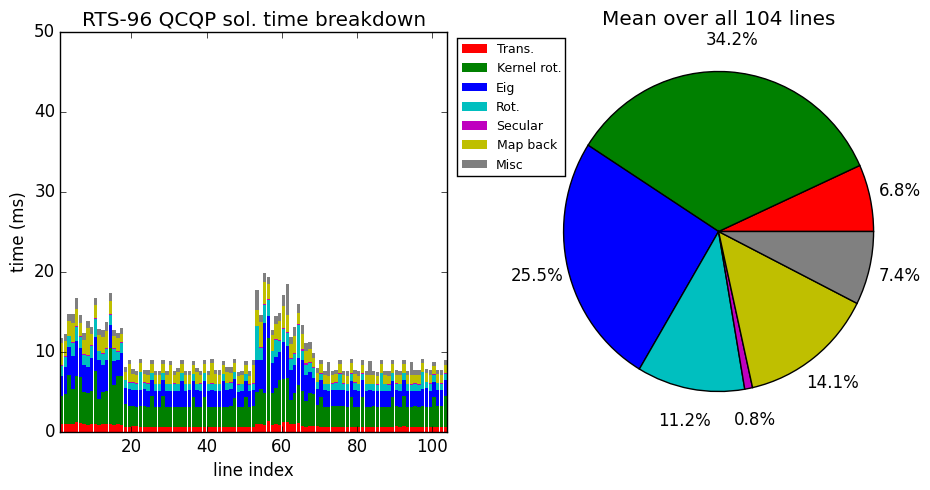

In [17]:
using PyPlot
PyPlot.svg(true)

t = load("../data/timing.jld")["timeVecs"]

tTrans    = [ti[1] for ti in t]*1e3
tKern     = [ti[2] for ti in t]*1e3
tEig      = [ti[3] for ti in t]*1e3
tRot      = [ti[4] for ti in t]*1e3
tSec      = [ti[5] for ti in t]*1e3
tMap      = [ti[6] for ti in t]*1e3
misc = outputData.linetimes*1e3 - (tMap+tSec+tRot+tEig+tKern+tTrans)

xvals = collect(1:length(tTrans))

fig = figure(figsize=(11,5))
subplot(1,2,1)
title("RTS-96 QCQP sol. time breakdown")
axis([1;length(xvals);0;50])
xlabel("line index")
ylabel("time (ms)")

bar(xvals, tTrans, color = "r", linewidth=0, width=0.9)
bar(xvals, tKern,  color = "g", bottom = tTrans, linewidth=0, width=0.9)
bar(xvals, tEig,   color = "b", bottom = tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tRot,   color = "c", bottom = tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tSec,   color = "m", bottom = tRot+tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, tMap,   color = "y", bottom = tSec+tRot+tEig+tKern+tTrans, linewidth=0, width=0.9)
bar(xvals, misc,   color = "k", bottom = tMap+tSec+tRot+tEig+tKern+tTrans, linewidth=0,width=0.9, alpha=0.5)

labels = ["Trans.";
    "Kernel rot.";
    "Eig";
    "Rot.";
    "Secular";
    "Map back";
    "Misc"]

legend(labels,loc=1,ncol=1,fontsize=9,
bbox_to_anchor=(1.32, 1.0))

subplot(1,2,2)
title("Mean over all 104 lines")
sizes = [mean(tTrans);
    mean(tKern);
    mean(tEig);
    mean(tRot);
    mean(tSec);
    mean(tMap);
    mean(misc)]
scale!(sizes,1/sum(sizes))

colors = ["r";
    "g";
    "b";
    "c";
    "m";
    "y";
    "gray"]

pie(sizes, colors=colors, autopct="%1.1f%%", pctdistance=1.2)
# tight_layout()
# savefig("../images/2015-11-02-timing-analysis-new-secular.pdf")

From 4.5% to 0.8%. Very nice!